In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os
import tol_colors as tc
from pathlib import Path
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from scipy.signal import correlate
from collections import Counter

# Berechnung Korrelation

In [2]:
def remove_jumps_from_euler_angle(
        angle_series: np.ndarray,
) -> np.ndarray:
    """
    Remove discontinuities (jumps > 330°) from Euler angle sequences.

    Parameters
    ----------
    angle_series : np.ndarray
        Array of shape (T,) with Euler angle values.

    Returns
    -------
    np.ndarray
        Smoothed angle array with jumps corrected.
    """
    t_diff = np.diff(angle_series, n=1)
    jump_indices = np.argwhere(np.abs(t_diff) > 330).flatten()
    corrected = np.copy(angle_series)

    for i in range(0, len(jump_indices), 2):
        delta = t_diff[jump_indices[i]]
        start = jump_indices[i] + 1
        if (i + 1) > (len(jump_indices) - 1):
            correction = -360 if delta > 0 else 360
            corrected[start:] += correction
        else:
            end = jump_indices[i + 1] + 1
            correction = -360 if delta > 0 else 360
            corrected[start:end] += correction

    return corrected


def load_data(base_path, subject_name, exercise_name):
    data_path = base_path / subject_name / exercise_name
    return pkl.load(open(data_path / 'imu_marker_deviations_second_version.pkl', 'rb'))


def preprocess_orientation_data(d):

    R_imu_marker = R.from_quat(d['marker_orientations'])
    R_imu_marker = R_imu_marker[:len(R_imu_marker)]
    R_imu = R.from_quat(d['imu_orientations'])

    max_ind = len(d['deviations_angles'])
    errors = list(set(d['error_indices']))
    errors = [x for x in errors if x < max_ind]

    marker_orientations = R_imu_marker.as_euler('xyz', degrees=True)
    marker_orientations[errors, :] = [0.0, 0.0, 0.0]
    marker_orientations[:, 0] = remove_jumps_from_euler_angle(marker_orientations[:, 0])
    marker_orientations[:, 1] = remove_jumps_from_euler_angle(marker_orientations[:, 1])
    marker_orientations[:, 2] = remove_jumps_from_euler_angle(marker_orientations[:, 2])

    imu_orientations = R_imu.as_euler('xyz', degrees=True)
    imu_orientations[errors, :] = [0.0, 0.0, 0.0]
    imu_orientations[:, 0] = remove_jumps_from_euler_angle(imu_orientations[:, 0])
    imu_orientations[:, 1] = remove_jumps_from_euler_angle(imu_orientations[:, 1])
    imu_orientations[:, 2] = remove_jumps_from_euler_angle(imu_orientations[:, 2])
    return marker_orientations, imu_orientations

def calculate_cross_corr(marker_orientations, imu_orientations, axis, chunk_size=250):
    corr_coeff = []
    for i in range(0, len(marker_orientations), chunk_size):
        marker_chunk = marker_orientations[i:i + chunk_size, axis]
        imu_chunk = imu_orientations[i:i + chunk_size, axis]

        marker_chunk = marker_chunk - np.mean(marker_chunk)
        imu_chunk = imu_chunk - np.mean(imu_chunk)

        corr = correlate(marker_chunk, imu_chunk, mode='full')
        lags = np.arange(-len(marker_chunk) + 1, len(imu_chunk))

        lag = lags[np.argmax(corr)]
        corr_coeff.append(lag)
    return Counter(corr_coeff).most_common()[:2]




In [3]:
base_path = Path('/Users/andi/Downloads/Data2')

exercise_name = 'gwo'

correlation_data = {}

for subject_name in  ['austra', 'darryl', 'elodie', 'erna', 'etsuko', 'gregers', 'hamit', 'hans', 'julia', 'jung-hee', 'katee', 'latifah', 'laurel', 'marquise', 'neves', 'rehema', 'rushda', 'yaxkin', 'ziri']:
    try:
        data = load_data(base_path, subject_name, exercise_name)
    except:
        continue
    subject_corr_data = {}
    for imu_name, imu_data in data.items():
        marker_orientations, imu_orientations = preprocess_orientation_data(imu_data)
        subject_corr_data[imu_name] =  calculate_cross_corr(marker_orientations, imu_orientations, 1)
    correlation_data[subject_name] = subject_corr_data



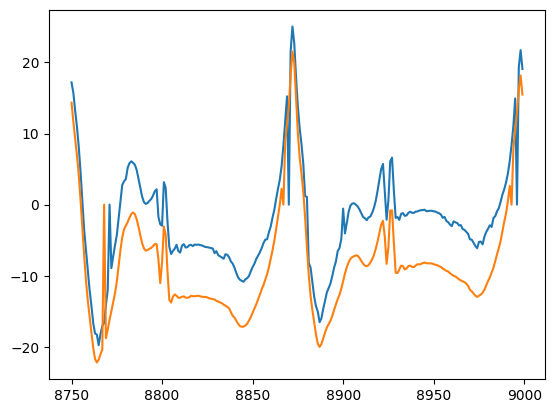

In [4]:
base_path = Path('/Users/andi/Downloads/Data2')
exercise_name = 'gwo'
subject_name = 'julia'
imu_name = 'calcn_r'

data = load_data(base_path, subject_name, exercise_name)
marker_orientations, imu_orientations = preprocess_orientation_data(data[imu_name])
subject_corr_data[imu_name] =  calculate_cross_corr(marker_orientations, imu_orientations, 1)

fig, axs = plt.subplots(1, 1)
offset = 3
chunk_size = 250
start = 35
stop = start + 1
start = start*chunk_size
stop = stop*chunk_size
time = np.arange(start, stop)
axs.plot(time, marker_orientations[start:stop, 0], label='marker orientations')
axs.plot(time, imu_orientations[(start+offset):(stop+offset), 0], label='imu orientations')
plt.show()